In [ ]:
# %load jump-start-bank-v003.py
# Jump-Start for the Bank Marketing Study
# as described in Marketing Data Science: Modeling Techniques
# for Predictive Analytics with R and Python (Miller 2015)

# jump-start code revised by Thomas W. Milller (2018/10/07)

# Scikit Learn documentation for this assignment:
# http://scikit-learn.org/stable/auto_examples/classification/
#   plot_classifier_comparison.html
# http://scikit-learn.org/stable/modules/generated/
#   sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB.score
# http://scikit-learn.org/stable/modules/generated/
#   sklearn.linear_model.LogisticRegression.html
# http://scikit-learn.org/stable/modules/model_evaluation.html 
# http://scikit-learn.org/stable/modules/generated/
#  sklearn.model_selection.KFold.html

# prepare for Python version 3x features and functions
# comment out for Python 3.x execution
# from __future__ import division, print_function
# from future_builtins import ascii, filter, hex, map, oct, zip

# the rest of the program should set up the modeling methods
# and evaluation within a cross-validation design

In [487]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

# import base packages into the namespace for this program
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [472]:
# initial work with the smaller data set
bank = pd.read_csv('bank.csv', sep = ';')  # start with smaller data set

# examine the shape of original input data
print(bank.shape)

(4521, 17)


In [8]:
# drop observations with missing data, if any
bank.dropna()
print(bank.shape)

(4521, 17)


In [6]:
# look at the list of column names, note that y is the response
list(bank.columns.values)

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'response']

In [305]:
# look at the beginning of the DataFrame
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [12]:
# mapping function to convert text no/yes to integer 0/1
convert_to_binary = {'no' : 0, 'yes' : 1}

In [13]:
# define binary variable for having credit in default
default = bank['default'].map(convert_to_binary)

In [15]:
# define binary variable for having a mortgage or housing loan
housing = bank['housing'].map(convert_to_binary)

In [16]:
# define binary variable for having a personal loan
loan = bank['loan'].map(convert_to_binary)

In [17]:
# define response variable to use in the model
response = bank['response'].map(convert_to_binary)

<Figure size 432x288 with 0 Axes>

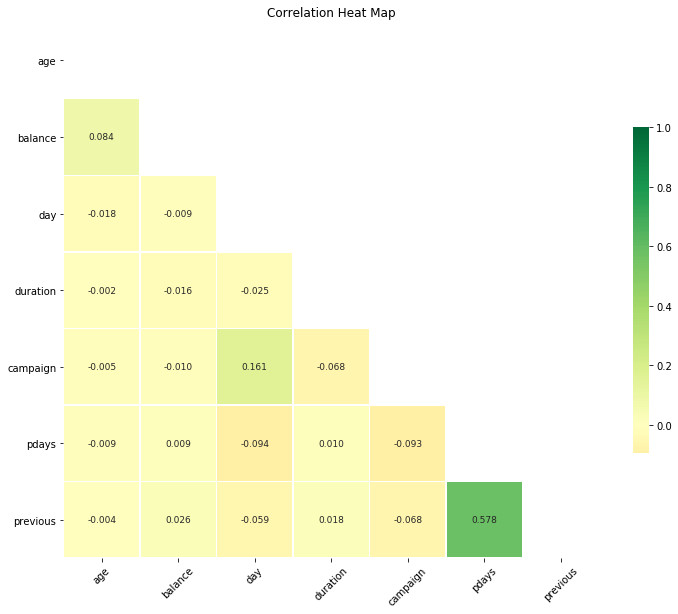

In [39]:
# correlation heat map setup for seaborn
def corr_chart(df_corr):
    corr=df_corr.corr()
    #screen top half to get a triangle
    top = np.zeros_like(corr, dtype=np.bool)
    top[np.triu_indices_from(top)] = True
    fig=plt.figure()
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr, mask=top, cmap='RdYlGn', 
        center = 0, square=True, 
        linewidths=.5, cbar_kws={'shrink':.5}, 
        annot = True, annot_kws={'size': 9}, fmt = '.3f')           
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')   
    plt.savefig('plot-corr-map.pdf', 
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
        orientation='portrait', papertype=None, format=None, 
        transparent=True, pad_inches=0.25, frameon=None)      

np.set_printoptions(precision=3)
corr_chart(df_corr = bank) 

In [40]:
# There is minimal multicollinearity between our predictor variables. The only place it exists is with our pdays and 
# previous variables showing that the more times you have been previously contacted the longer period of days there is
# in between being last contacted. This inherently makes sense because if you never were previously contacted then you
# have no days since your last contact.

In [41]:
# look at summary
bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [42]:
# Average age of 41 with a balance of $1422. Average contact duration is about 264 seconds or about 4.4 minutes.

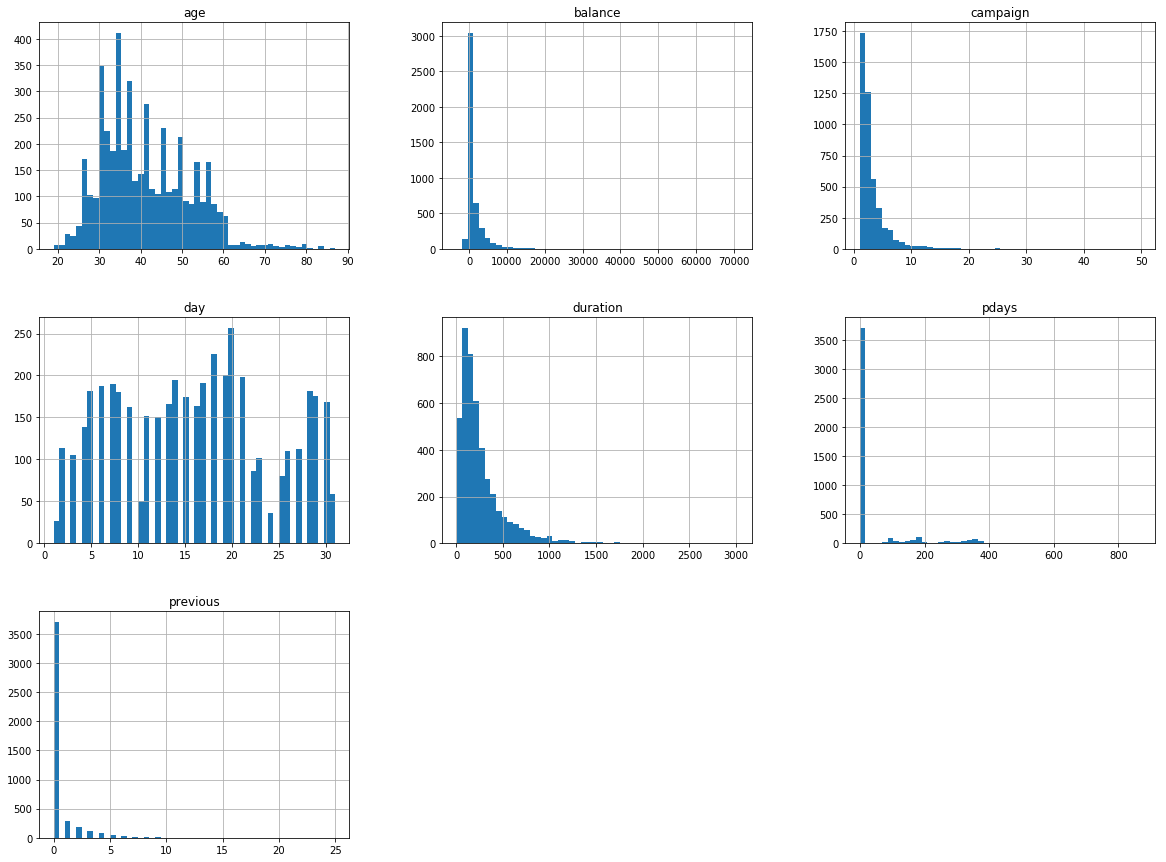

In [67]:
# view histograms of numeric variables
bank.hist(bins=50, figsize=(20,15))
plt.show()

In [45]:
# There is heavy right skewing going on with most of these variables except day. Outliers may need to be imputted.

In [46]:
# look at means for response variables
bank.groupby('response').mean()

,age,balance,day,duration,campaign,pdays,previous
response,,,,,,,
no,40.998000,1403.211750,15.948750,226.347500,2.862250,36.006000,0.471250
yes,42.491363,1571.955854,15.658349,552.742802,2.266795,68.639155,1.090211


In [ ]:
# Yes respondents are slightly older, have a slightly higher balance, had a much higher contact duration and had a
# longer time period in between previous contact. Also, they were contacted slightly less times on average during the
# campaign.

In [47]:
# look at default variables means
bank.groupby('default').mean()

,age,balance,day,duration,campaign,pdays,previous
default,,,,,,,
no,41.194826,1450.550956,15.929584,264.355906,2.79865,40.111136,0.548481
yes,39.723684,-208.723684,15.078947,240.881579,2.50000,19.618421,0.197368


In [48]:
# Defaulting on a loan shows a slightly younger age, far less balance (obviously) and also less contacts before the 
# last campaign.

In [49]:
# look at housing variable means
bank.groupby('housing').mean()

,age,balance,day,duration,campaign,pdays,previous
housing,,,,,,,
no,43.511723,1595.277268,16.209990,259.290520,2.80632,26.402141,0.467890
yes,39.374756,1290.309496,15.689332,267.542399,2.78390,50.013286,0.599844


In [50]:
# slightly younger, slightly smaller average balance

In [52]:
# Look at personal loan variable means
bank.groupby('loan').mean()

,age,balance,day,duration,campaign,pdays,previous
loan,,,,,,,
no,41.220627,1513.857963,15.932376,264.512794,2.771018,41.088512,0.558486
yes,40.890014,917.163531,15.820550,260.904486,2.918958,32.439942,0.454414


In [53]:
# Smaller balance otherwise minimal differences

In [476]:
# look at response counts
bank['response'].value_counts()

0    4000
1     521
Name: response, dtype: int64

In [477]:
521/4521

0.11523999115239991

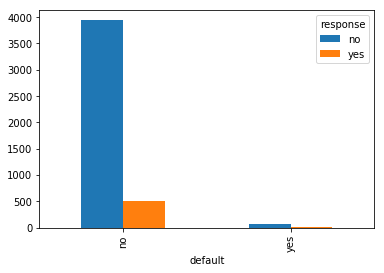

In [60]:
# look at some cross tabs of variables
pd.crosstab(bank.default, bank.response).plot(kind='bar')

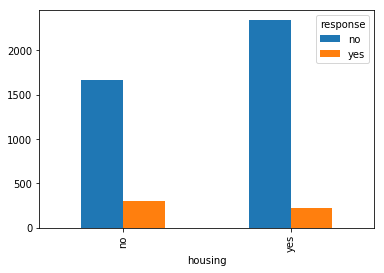

In [62]:
pd.crosstab(bank.housing, bank.response).plot(kind='bar')

In [63]:
# customers with no housing loan seem more likely to subscribe to a term deposit

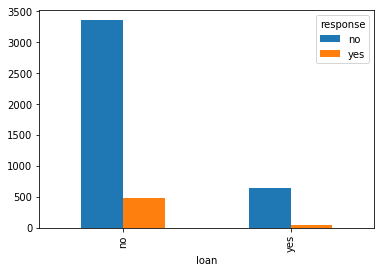

In [64]:
pd.crosstab(bank.loan, bank.response).plot(kind='bar')

In [65]:
# same with a personal loan

In [ ]:
##################################################################
# first run model with 3 variables (housing, default, loan) only
##################################################################

In [86]:
# gather three explanatory variables and response into a numpy array 
# here we use .T to obtain the transpose for the structure we want
model_data = np.array([np.array(default), np.array(housing), np.array(loan), 
    np.array(response)]).T

In [68]:
# examine the shape of model_data, which we will use in subsequent modeling
print(model_data.shape)

(4521, 4)


In [100]:
# run logistic regression with only housing, default, loan variables
X = model_data[:, 0:3]
y = model_data[:, 3]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [145]:
# initialize and fit model
logreg1 = LogisticRegression(C = 1).fit(X_train, y_train)
print("Training set score: {:.4f}".format(logreg1.score(X_train, y_train)))
print("Test set score: {:.4f}".format(logreg1.score(X_test, y_test)))

Training set score: 0.8881
Test set score: 0.8769


In [173]:
# Evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

[0.883 0.885 0.885 0.885 0.885 0.885 0.885 0.885 0.885 0.885]
0.8847603977417025


In [321]:
# look at confusion matrix
y_train_pred1 = cross_val_predict(logreg1, X_train, y_train, cv=10)
confusion_matrix(y_train, y_train_pred1)

array([[2810,    0],
       [ 354,    0]])

In [160]:
# I am concerned about not seeing any positive predicitions in my confusion matrix. That doesn't seem right. I will 
# try to balance my 1's and 0's a bit more to see if that changes things.

In [215]:
# Get scores of all instances in training set, but specify you only want decision scores returned
y_scores = cross_val_predict(logreg1, X_train, y_train, cv=10, method = "decision_function")

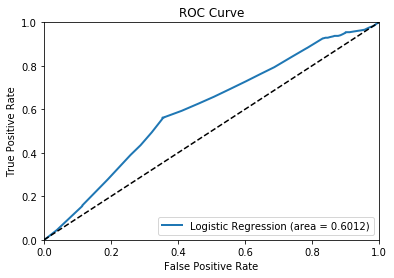

In [258]:
# Plot ROC
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
logit_roc_auc = roc_auc_score(y_train, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC Curve")
    plt.legend(loc="lower right")

plot_roc_curve(fpr, tpr, label='Logistic Regression (area = %0.4f)' %logit_roc_auc)
plt.show()

In [217]:
# ROC AUC
roc_auc_score(y_train, y_scores)

0.6011807105374268

In [218]:
# A very low ROC AUC score. Model is not optimal!

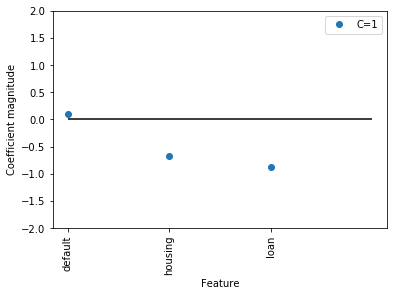

In [300]:
# view model coefficients
plt.plot(logreg1.coef_.T, 'o', label="C=1")
plt.xticks(range(model_data.shape[1]-1), ['default', 'housing', 'loan'], rotation=90)
plt.hlines(0, 0, model_data.shape[1]-1)
plt.ylim(-2, 2)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()

In [301]:
# From this you could argue not having a personal loan and/or housing loan are more important to subscribing to a term
# deposit

In [219]:
# Because of our low instances of 1's for our response, I will try a balance measure to see if that helps with prediction
logreg2 = LogisticRegression(C = 1, class_weight = 'balanced').fit(X_train, y_train)
print("Training set score: {:.4f}".format(logreg2.score(X_train, y_train)))
print("Test set score: {:.4f}".format(logreg2.score(X_test, y_test)))

Training set score: 0.6369
Test set score: 0.6441


In [220]:
# Performance seemed to decrease compared to first model

In [226]:
y_scores2 = cross_val_predict(logreg2, X_train, y_train, cv=10)

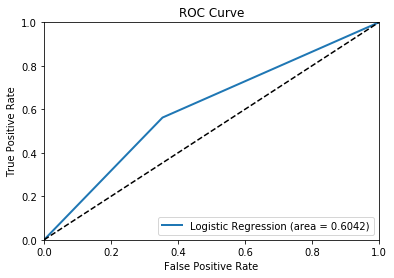

In [256]:
# Plot ROC
fpr, tpr, thresholds = roc_curve(y_train, y_scores2)
logit_roc_auc = roc_auc_score(y_train, y_scores2)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC Curve")
    plt.legend(loc="lower right")

plot_roc_curve(fpr, tpr, label='Logistic Regression (area = %0.4f)' %logit_roc_auc)
plt.show()

In [228]:
# ROC AUC
roc_auc_score(y_train, y_scores2)

0.6042051189255484

In [322]:
y_train_pred2 = cross_val_predict(logreg2, X_train, y_train, cv=10)
confusion_matrix(y_train, y_train_pred2)

array([[1816,  994],
       [ 155,  199]])

In [325]:
# Look at table of evaluation metrics
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_train,y_train_pred2))

              precision    recall  f1-score   support

           0       0.92      0.65      0.76      2810
           1       0.17      0.56      0.26       354

   micro avg       0.64      0.64      0.64      3164
   macro avg       0.54      0.60      0.51      3164
weighted avg       0.84      0.64      0.70      3164



In [230]:
# ROC AUC score slightly improved. Our confusion matrix also showed improvement by actually predicting positive outcomes

In [545]:
rf = RandomForestClassifier(class_weight = 'balanced').fit(X_train, y_train)
print("Training set score: {:.4f}".format(rf.score(X_train, y_train)))
print("Test set score: {:.4f}".format(rf.score(X_test, y_test)))

Training set score: 0.9902
Test set score: 0.8836


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [234]:
# I will try to build a random forest classifier to see how that compares
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=10, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train,y_scores_forest)

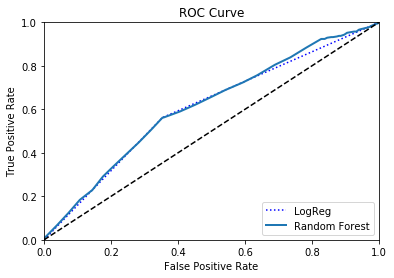

In [257]:
# Plot ROC from RandomForest
plt.plot(fpr, tpr, "b:", label="LogReg")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# There is slight improvement from the RandomForest classifier, but marginal at best.

In [236]:
roc_auc_score(y_train, y_scores_forest)

0.6112496732814604

In [326]:
# Naive Bayes
nb1 = BernoulliNB(fit_prior = False).fit(X_train, y_train)
print("Training set score: {:.4f}".format(nb1.score(X_train, y_train)))
print("Test set score: {:.4f}".format(nb1.score(X_test, y_test)))

Training set score: 0.6369
Test set score: 0.6441


In [327]:
# Evaluate the model using 10-fold cross-validation
scoresNB = cross_val_score(BernoulliNB(), X, y, scoring='accuracy', cv=10)
print(scoresNB)
print(scoresNB.mean())

[0.883 0.885 0.885 0.885 0.885 0.885 0.885 0.885 0.885 0.885]
0.8847603977417025


In [328]:
# Confusion matrix for nb
y_train_pred_NB = cross_val_predict(nb1, X_train, y_train, cv=10)
confusion_matrix(y_train, y_train_pred_NB)

array([[1816,  994],
       [ 155,  199]])

In [329]:
y_scores_NB = cross_val_predict(nb1, X_train, y_train, cv=10)
roc_auc_score(y_train, y_scores_NB)

0.6042051189255484

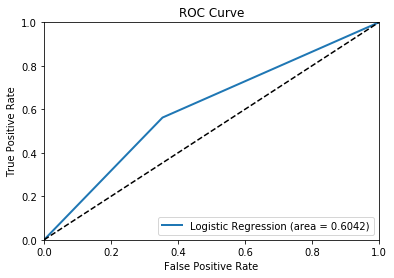

In [330]:
# Plot ROC
fpr, tpr, thresholds = roc_curve(y_train, y_scores_NB)
nb_roc_auc = roc_auc_score(y_train, y_scores_NB)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC Curve")
    plt.legend(loc="lower right")

plot_roc_curve(fpr, tpr, label='Logistic Regression (area = %0.4f)' %nb_roc_auc)
plt.show()

In [481]:
# Try with full model and regularization
# create new df
bank3 = bank

In [474]:
# Need to create indicator values for all categorical vars

# create a list of columns with yes/no values to convert to 0 and 1
list_binary = ['default', 'housing', 'loan', 'response']

# loop through those columns and replace yes/no values with 0 and 1
for X in list_binary: 
    bank3[X] = pd.Series(np.searchsorted(['no', 'yes'], bank3[X]), bank3.index)

# create a list of any categorical column to create dummy variables:
list_dummies = ['job', 'marital', 'education','contact', 'month','poutcome']

# use the pd 'get_dummies' method to create dummy variables for all object lists: 
for column_name in list_dummies:
    dummies = pd.get_dummies(bank3[column_name])
    col_names_dummies = dummies.columns.values

    # then you can append new columns to the dataframe
    for i,value in enumerate(col_names_dummies):
        bank3[value] = dummies.iloc[:,i]

# drop categorical columns and keep dummy columns:
bank3 = bank3.drop(columns=['job', 'marital', 'education',\
                                        'contact', 'month','poutcome'], axis = 1)
# df_bank_imp = df_bank_imp.rename(columns={'value_yes': 'y_target_yes'})
bank3.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'pdays', 'previous', 'response', 'admin.', 'blue-collar',
       'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed',
       'services', 'student', 'technician', 'unemployed', 'unknown',
       'divorced', 'married', 'single', 'primary', 'secondary', 'tertiary',
       'cellular', 'telephone', 'apr', 'aug', 'dec', 'feb', 'jan', 'jul',
       'jun', 'mar', 'may', 'nov', 'oct', 'sep', 'failure', 'other',
       'success'],
      dtype='object')

In [475]:
# Change order of columns so that response variable is furthest to the right
bank3 = bank3[['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'pdays', 'previous', 'admin.', 'blue-collar',
       'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed',
       'services', 'student', 'technician', 'unemployed', 'unknown',
       'divorced', 'married', 'single', 'primary', 'secondary', 'tertiary',
       'cellular', 'telephone', 'apr', 'aug', 'dec', 'feb', 'jan', 'jul',
       'jun', 'mar', 'may', 'nov', 'oct', 'sep', 'failure', 'other',
       'success', 'response']]
bank3.head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,jun,mar,may,nov,oct,sep,failure,other,success,response
0,30,0,1787,0,0,19,79,1,-1,0,...,0,0,0,0,1,0,0,0,0,0
1,33,0,4789,1,1,11,220,1,339,4,...,0,0,1,0,0,0,1,0,0,0
2,35,0,1350,1,0,16,185,1,330,1,...,0,0,0,0,0,0,1,0,0,0
3,30,0,1476,1,1,3,199,4,-1,0,...,1,0,0,0,0,0,0,0,0,0
4,59,0,0,1,0,5,226,1,-1,0,...,0,0,1,0,0,0,0,0,0,0


In [478]:
bank4 = bank3.copy()

# split dataframe by data and response variables and make array for train_test_split
# remove response variable from data and save as df_data
bank3_data = bank4.drop(columns=['response'])
#remove all but response variable and save as df_response
bank3_response = bank4.drop(columns=['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'pdays', 'previous', 'admin.', 'blue-collar',
       'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed',
       'services', 'student', 'technician', 'unemployed', 'unknown',
       'divorced', 'married', 'single', 'primary', 'secondary', 'tertiary',
       'cellular', 'telephone', 'apr', 'aug', 'dec', 'feb', 'jan', 'jul',
       'jun', 'mar', 'may', 'nov', 'oct', 'sep', 'failure', 'other',
       'success'])

# transform data and response dataframes with same index to array
bank3_data_array = np.array(bank3_data.to_records().view(type=np.matrix))
bank3_response_array = np.array(bank3_response.to_records().view(type=np.matrix))

In [482]:
# split data by training & test set with 70/30 split
X = bank3_data
y = bank3_response
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [514]:
# fit model
logregfull = LogisticRegression(C=1, penalty="l1").fit(X_train, y_train)
print("Training set score: {:.4f}".format(logregfull.score(X_train, y_train)))
print("Test set score: {:.4f}".format(logregfull.score(X_test, y_test)))

Training set score: 0.9080
Test set score: 0.8939


In [515]:
# Evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

[0.887 0.896 0.896 0.912 0.896 0.907 0.887 0.92  0.918 0.9  ]
0.9020160581374904


In [516]:
# Look at confusion matrix
y_train_full = cross_val_predict(logregfull, X_train, y_train, cv=10)
confusion_matrix(y_train, y_train_full)

array([[2753,   57],
       [ 250,  104]])

In [517]:
# Get scores of all instances in training set, but specify you only want decision scores returned
y_scores_full = cross_val_predict(logregfull, X_train, y_train, cv=10, method = "decision_function")

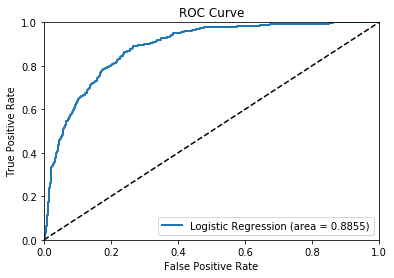

In [518]:
# Plot ROC
fpr, tpr, thresholds = roc_curve(y_train, y_scores_full)
logit_roc_auc = roc_auc_score(y_train, y_scores_full)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC Curve")
    plt.legend(loc="lower right")

plot_roc_curve(fpr, tpr, label='Logistic Regression (area = %0.4f)' %logit_roc_auc)
plt.show()

In [519]:
# much better plot!!

In [520]:
# look at table of evaluation metrics
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_train,y_train_full))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2810
           1       0.65      0.29      0.40       354

   micro avg       0.90      0.90      0.90      3164
   macro avg       0.78      0.64      0.68      3164
weighted avg       0.89      0.90      0.89      3164



In [521]:
# ROC AUC
roc_auc_score(y_train, y_scores_full)

0.8855047550113598

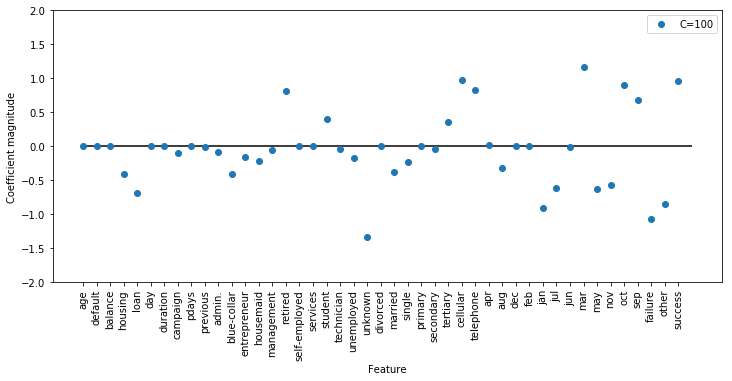

In [540]:
# view model coefficients
plt.figure(figsize=(12,5))
plt.plot(logregfull.coef_.T, 'o', label="C=100")
plt.xticks(range(bank3_data.shape[1]), bank3_data.columns, rotation = 90)
plt.hlines(0, 0, bank3_data.shape[1])
plt.ylim(-2, 2)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()

In [541]:
# From this I can get some insight into the most important features in determining if a customer will subscribe to a 
# term desposit